In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime

from datetime import timedelta, datetime, date
import calendar

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob

# Load Data

In [2]:
ds_merged_allM = xr.open_dataset('ds_merged_EMC_allM.nc')

# Calculate ensemble means, and areal means

In [3]:
ds_merged = ds_merged_allM.mean('M')
ds_merged_mean = ds_merged.mean(['lat','lon'])

# The packages that run Logistic regressions and other model fitting work on pandas Dataframe. 

# Because of this I transformed the xarrayDatasets to pandas.Dataframes.

# I believe that there could be ways to avoid that, but given that our data are not "Big Data", we can handle it this way.

In [4]:
# transform to dataframe
df_merged = ds_merged[['apcp','pr','tas','tdps','cape']].to_dataframe()
df_merged.head(5)
#it's now nested

apcp        pr         tas        tdps  \
T                   lat  lon                                                 
1999-06-03 12:00:00 32.0 257.0  0.037341  0.585714  302.508087  279.933777   
                         258.0  0.177661  0.715065  302.152191  284.864960   
                         259.0  0.322088  0.576623  302.282349  287.261047   
                         260.0  0.454268  0.485714  302.188538  288.628601   
                         261.0  0.267235  0.255714  301.619476  290.136353   

                                      cape          S  
T                   lat  lon                           
1999-06-03 12:00:00 32.0 257.0  440.038940 1999-06-02  
                         258.0  759.519470 1999-06-02  
                         259.0  896.039062 1999-06-02  
                         260.0  888.779236 1999-06-02  
                         261.0  917.792175 1999-06-02

In [5]:
# reset index, which now it's simply a numerical index
df_merged = df_merged.reset_index()
df_merged.head(5)

,T,lat,lon,apcp,pr,tas,tdps,cape,S
0,1999-06-03 12:00:00,32.0,257.0,0.037341,0.585714,302.508087,279.933777,440.038940,1999-06-02
1,1999-06-03 12:00:00,32.0,258.0,0.177661,0.715065,302.152191,284.864960,759.519470,1999-06-02
2,1999-06-03 12:00:00,32.0,259.0,0.322088,0.576623,302.282349,287.261047,896.039062,1999-06-02
3,1999-06-03 12:00:00,32.0,260.0,0.454268,0.485714,302.188538,288.628601,888.779236,1999-06-02
4,1999-06-03 12:00:00,32.0,261.0,0.267235,0.255714,301.619476,290.136353,917.792175,1999-06-02


In [6]:
# #remane it  and then set index == T
df_merged.index.names = ['orig_rows']
df_merged = df_merged.reset_index().set_index('T')
df_merged.head(5)

,orig_rows,lat,lon,apcp,pr,tas,tdps,cape,S
T,,,,,,,,,
1999-06-03 12:00:00,0,32.0,257.0,0.037341,0.585714,302.508087,279.933777,440.038940,1999-06-02
1999-06-03 12:00:00,1,32.0,258.0,0.177661,0.715065,302.152191,284.864960,759.519470,1999-06-02
1999-06-03 12:00:00,2,32.0,259.0,0.322088,0.576623,302.282349,287.261047,896.039062,1999-06-02
1999-06-03 12:00:00,3,32.0,260.0,0.454268,0.485714,302.188538,288.628601,888.779236,1999-06-02
1999-06-03 12:00:00,4,32.0,261.0,0.267235,0.255714,301.619476,290.136353,917.792175,1999-06-02


In [7]:
# Re-do the same thing for the other dataset
df_merged_mean = ds_merged_mean[['apcp','pr','tas','tdps','cape']].to_dataframe()
df_merged_mean = df_merged_mean.reset_index()
df_merged_mean.index.names = ['orig_rows']
df_merged_mean = df_merged_mean.reset_index().set_index('T')
df_merged_mean.head(5)

,orig_rows,apcp,pr,tas,tdps,cape,S
T,,,,,,,
1999-06-03 12:00:00,0,0.256931,2.461444,299.555054,287.567566,1081.592529,1999-06-02
1999-06-10 12:00:00,1,0.723767,5.848172,297.214691,288.922333,653.793091,1999-06-09
1999-06-17 12:00:00,2,0.437628,1.452879,297.498871,286.428101,542.377014,1999-06-16
1999-06-24 12:00:00,3,0.752838,3.789541,300.283844,290.532318,1205.066406,1999-06-23
1999-07-01 12:00:00,4,0.269029,1.574788,301.867737,290.326355,1007.021301,1999-06-30


# Below I define a few optimized functions

In [8]:
import bottleneck

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])


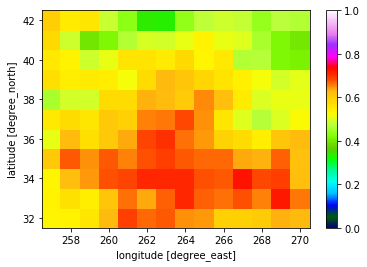

In [9]:
spearman_correlation(ds_merged.apcp, ds_merged.pr/8.,'T').plot(vmin=0,vmax=1, cmap='gist_ncar')

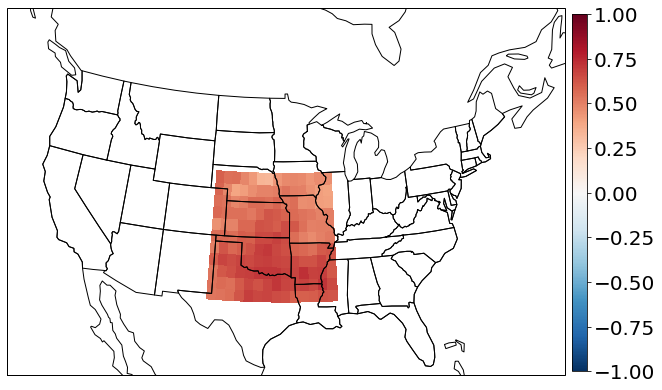

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize = (10,8))
cbar_ax = fig.add_axes([.91, 0.19, .02, 0.62])
cbar_ax.tick_params(labelsize=20)
central_lat = 37.5
central_lon = -96
extent = [-122, -68, 22, 55]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))

ax.set_extent(extent)
sc_dataarray = spearman_correlation(ds_merged.apcp, ds_merged.pr/8.,'T')
ax.add_feature(cfeature.STATES)
ax.coastlines()

pt = sc_dataarray.plot(ax=ax, transform=ccrs.PlateCarree(), cmap = 'RdBu_r',
                                cbar_ax=cbar_ax, vmin=-1, vmax=1)

# Prepare dataframe to be ingested in the model fitting

### fix units

In [11]:
df_merged['pr']= df_merged['pr']/8 # 3 hourly and not daily
df_merged[0:17500].tail(5)

,orig_rows,lat,lon,apcp,pr,tas,tdps,cape,S
T,,,,,,,,,
2007-08-02 12:00:00,17495,38.0,266.0,0.007340,0.009740,301.376099,292.367554,505.870087,2007-08-01
2007-08-02 12:00:00,17496,38.0,267.0,0.042064,0.019481,301.947937,290.753265,333.402588,2007-08-01
2007-08-02 12:00:00,17497,38.0,268.0,0.033205,0.013474,302.254547,290.177948,265.116913,2007-08-01
2007-08-02 12:00:00,17498,38.0,269.0,0.098342,0.006494,302.170929,290.101318,251.311676,2007-08-01
2007-08-02 12:00:00,17499,38.0,270.0,0.130875,0.016721,303.693390,289.093506,236.519470,2007-08-01


In [12]:
df_merged_mean['pr']= df_merged_mean['pr']/8 # 3 hourly and not daily
df_merged_mean.head(5)

,orig_rows,apcp,pr,tas,tdps,cape,S
T,,,,,,,
1999-06-03 12:00:00,0,0.256931,0.307680,299.555054,287.567566,1081.592529,1999-06-02
1999-06-10 12:00:00,1,0.723767,0.731022,297.214691,288.922333,653.793091,1999-06-09
1999-06-17 12:00:00,2,0.437628,0.181610,297.498871,286.428101,542.377014,1999-06-16
1999-06-24 12:00:00,3,0.752838,0.473693,300.283844,290.532318,1205.066406,1999-06-23
1999-07-01 12:00:00,4,0.269029,0.196849,301.867737,290.326355,1007.021301,1999-06-30


### add 'y' variable

In [13]:
df_merged['y']=df_merged.apcp*1.
df_merged_mean['y']=df_merged_mean.apcp*1.


### add log of variables


In [14]:
df_merged['logpr'] = np.log(df_merged['pr'])
df_merged_mean['logpr'] = np.log(df_merged_mean['pr'])
# clean weird values post log
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged = df_merged.dropna()

df_merged['logcape'] = np.log(df_merged['cape'])
df_merged_mean['logcape'] = np.log(df_merged_mean['cape'])
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged = df_merged.dropna()

df_merged['logtas'] = np.log(df_merged['tas'])
df_merged_mean['logtas'] = np.log(df_merged_mean['tas'])
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged = df_merged.dropna()

df_merged['logtdps'] = np.log(df_merged['tdps'])
df_merged_mean['logtdps'] = np.log(df_merged_mean['tdps'])
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged = df_merged.dropna()

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [15]:
df_merged_mean.describe()

,orig_rows,apcp,pr,tas,tdps,cape,y,logpr,logcape,logtas,logtdps
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,65.000000,0.362923,0.284862,301.269836,287.069794,546.467102,0.362923,-1.465288,6.196689,5.707979,5.659703
std,37.960506,0.190639,0.178133,2.263517,1.851082,236.289902,0.190639,0.684598,0.496382,0.007520,0.006458
min,0.000000,0.046803,0.041472,295.221741,282.421082,74.198685,0.046803,-3.182737,4.306746,5.687727,5.643399
25%,32.500000,0.214524,0.153717,299.478806,285.966492,387.307663,0.214524,-1.872641,5.959217,5.702044,5.655875
50%,65.000000,0.330463,0.247544,301.437592,287.369232,534.573730,0.330463,-1.396166,6.281470,5.708563,5.660768
75%,97.500000,0.470224,0.393729,302.901932,288.466446,650.967468,0.470224,-0.932269,6.478450,5.713409,5.664579
max,130.000000,1.004915,0.881300,305.651794,290.532318,1205.066406,1.004915,-0.126358,7.094290,5.722446,5.671715


### Finalizing dataframe

In [16]:
Xall = df_merged[['orig_rows','apcp','pr','tas','tdps','cape','logpr','logcape','logtas','logtdps']]
yall = df_merged.loc[:, df_merged.columns == 'y']
# add 1 to fit the b_0 values. 
Xall['const']=1

Xm = df_merged_mean[['orig_rows','apcp','pr','tas','tdps','cape','logpr','logcape','logtas','logtdps']]
ym = df_merged_mean.loc[:, df_merged_mean.columns == 'y']
Xm['const']=1

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Load all packages

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import log_loss

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report

In [19]:
def random_walk_mike(REAL, PREDICTION_A, PREDICTION_B,firstmodel,secondmodel):
    if len(y_trainT.shape)==2:
        REAL = REAL.values[:,0]
    elif len(y_trainT.shape)==1:
        REAL = REAL.values[:]
        
    AA = ((REAL-PREDICTION_A.values)**2)**(1/2.)
    BB = ((REAL-PREDICTION_B.values)**2)**(1/2.)
    better_AA = AA<BB
    better_AA = better_AA.astype(int)
    better_AA[better_AA==0]=-1
    plt.plot(np.cumsum(better_AA), label=secondmodel)
    plt.title(firstmodel)
    plt.legend( bbox_to_anchor=(1.3, 1))
#     plt.yscale('symlog')

In [20]:
# def random_walk_mike_map_BSS(TIMEINDEX, REAL, PREDICTION_A, PREDICTION_B,CLIMO,firstmodel,secondmodel,ax):
#     if len(y_trainT.shape)==2:
#         REAL = REAL.values[:,0]
#     elif len(y_trainT.shape)==1:
#         REAL = REAL.values[:]
#     df_temp = TIMEINDEX
#     df_temp['REAL']= REAL
#     df_temp['PA'] = PREDICTION_A.values
#     df_temp['PB'] = PREDICTION_B.values
#     df_temp['CL'] = CLIMO.values
#     print(df_temp.head(10))
#     AA=np.zeros((pd.unique(df_temp['T']).shape))
#     BB=np.zeros((pd.unique(df_temp['T']).shape))
#     CC=np.zeros((pd.unique(df_temp['T']).shape))

#     for ik,(k,gp) in enumerate(df_temp.groupby('T')):
       
#         AA[ik] = np.sum((gp.REAL.values-gp.PA.values)**2)
#         BB[ik] = np.sum((gp.REAL.values-gp.PB.values)**2)
#         CC[ik] = np.sum((gp.REAL.values-gp.CL.values)**2)
#     AA = 1.-AA/CC
#     BB = 1.-BB/CC
    
#     better_AA = AA>BB
#     better_AA = better_AA.astype(int)
#     better_AA[better_AA==0]=-1
#     ax.plot(np.cumsum(better_AA), label=secondmodel)
#     ax.set_title(firstmodel)
#     ax.legend( bbox_to_anchor=(1.1, 1))
#     #     plt.yscale('symlog')

def random_walk_mike_map_BSS(REAL, PREDICTION_A, PREDICTION_B,CLIMO,firstmodel,secondmodel,ax,colorplot,legendflag=0):
#     if len(y_trainT.shape)==2:
#         REAL = REAL.values[:,0]
#     elif len(y_trainT.shape)==1:
#         REAL = REAL.values[:]
#     df_temp = TIMEINDEX
    df_temp= REAL.to_frame('REAL')
    df_temp['PA'] = PREDICTION_A.values
    df_temp['PB'] = PREDICTION_B.values
    df_temp['CL'] = CLIMO.values
    AA=np.zeros((pd.unique(df_temp.index).shape))
    BB=np.zeros((pd.unique(df_temp.index).shape))
    CC=np.zeros((pd.unique(df_temp.index).shape))

    for ik,(k,gp) in enumerate(df_temp.groupby('T')):
       
        AA[ik] = np.sum((gp.REAL.values-gp.PA.values)**2)
        BB[ik] = np.sum((gp.REAL.values-gp.PB.values)**2)
        CC[ik] = np.sum((gp.REAL.values-gp.CL.values)**2)
    AA = 1.-AA/CC
    BB = 1.-BB/CC
    
    better_AA = AA>BB
    better_AA = better_AA.astype(int)
    better_AA[better_AA==0]=-1
    ax.plot(np.cumsum(better_AA), label=secondmodel, color=colorplot)
    ax.set_title(firstmodel)
    if legendflag==1:
        ax.legend( bbox_to_anchor=(1.1, 1))
    #     plt.yscale('symlog')

In [21]:
def random_walk_mike_map(REAL, PREDICTION_A, PREDICTION_B,firstmodel,secondmodel,ax,colorplot,legendflag=0):
#     if len(y_trainT.shape)==2:
#         REAL = REAL.values[:,0]
#     elif len(y_trainT.shape)==1:
#         REAL = REAL.values[:]
#     df_temp = TIMEINDEX
    df_temp= REAL.to_frame('REAL')
    df_temp['PA'] = PREDICTION_A.values
    df_temp['PB'] = PREDICTION_B.values
    AA=np.zeros((pd.unique(df_temp.index).shape))
    BB=np.zeros((pd.unique(df_temp.index).shape))
    for ik,(k,gp) in enumerate(df_temp.groupby('T')):
        AA[ik] = np.nansum((gp.REAL.values-gp.PA.values)**2)
        BB[ik] = np.nansum((gp.REAL.values-gp.PB.values)**2)
#     print(AA,BB)
    better_AA = AA<BB

    better_AA = better_AA.astype(int)
    better_AA[better_AA==0]=-1
    ax.plot(np.cumsum(better_AA), label=secondmodel, color=colorplot)
    ax.set_title(firstmodel)
    if legendflag==1:
        ax.legend( bbox_to_anchor=(1.1, 0.5), loc='center left')
    return np.cumsum(better_AA)[-1]
#         plt.yscale('symlog')

In [22]:
def missing_elements(L,start,end):
#     start, end = L[0], L[-1]
    return sorted(set(range(start, end + 1)).difference(L))


/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

AUC  0.9207683073229291
['const', 'logpr']
AF  0.0
[]
F  -16.0
['const', 'logpr', 'logtas', 'logtdps']


/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

AUC  0.8857142857142857
['const', 'logpr']
AF  0.0
[]
F  -20.0
['const', 'logpr', 'logtas', 'logtdps']


/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

AUC  0.9798387096774194
['const', 'logpr', 'logtas']
AF  0.0
[]
F  -14.0
['const', 'logpr', 'logcape', 'logtas']


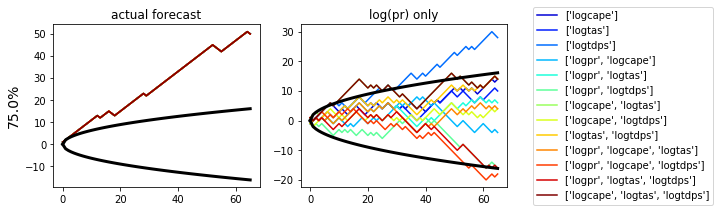

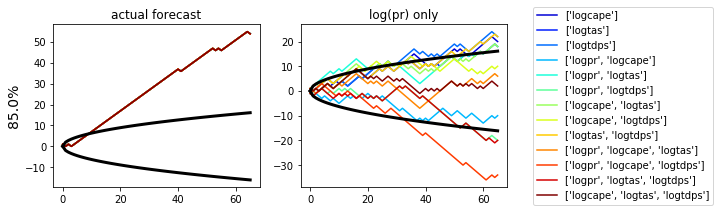

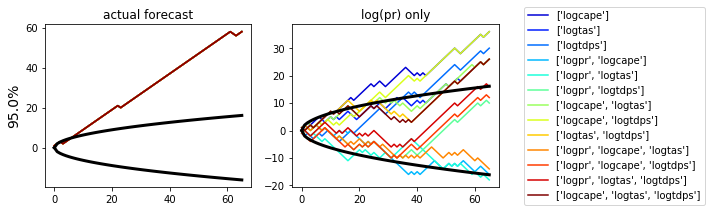

In [24]:
# This flag switches between using ensemble mean (MEDIA=1) and all members (MEDIA=!1)
MEDIA = 1

if MEDIA ==1:
    X = Xm*1.
    y = ym*1.
else:
    X = Xall*1.
    y = yall*1.

threshold_perc_list = [0.75,0.85,0.95]


from itertools import combinations
import random

# set threshold percentile
threshold_perc = 0.85

# set randomness . 1 for random, 0 for split time series
randpick=0
import random

if randpick==1:
#     picktrain = np.random.randint(0,int(X.shape[0]),int(X.shape[0]/2))
    # I pick values from the index, remember that I dropped a bunch of NaN so some index values are missing
    
#     picktrain = random.sample(range(X.shape[0]), int(X.shape[0]/2))
#     picktrain = np.sort(picktrain)
#     picktest = missing_elements(picktrain,0,int(X.shape[0])-1)
    X_trainT = X.iloc[picktrain]
    X_testT = X.iloc[picktest]
    y_trainT = y.iloc[picktrain]
    y_testT = y.iloc[picktest]                                  
                                  
#     X_trainT, X_testT, y_trainT, y_testT = train_test_split(X, y, test_size=0.5, random_state=0)
elif randpick==0:
    X_trainT = X[0:int(X.shape[0]/2)]
    y_trainT = y[0:int(X.shape[0]/2)].astype(int)
    X_testT = X[int(X.shape[0]/2):]
    y_testT = y[int(X.shape[0]/2):].astype(int)
elif randpick==-1:
    X_trainT = X[int(X.shape[0]/2):]
    y_trainT = y[int(X.shape[0]/2):].astype(int)
    X_testT = X[0:int(X.shape[0]/2)]
    y_testT = y[0:int(X.shape[0]/2)].astype(int)

for it,threshold_perc in enumerate(threshold_perc_list):
    # calculate occurrence and non occurence based on insample quantile so no leaking.
    y_trainT=(X_trainT.apcp>=X_trainT.quantile(threshold_perc).apcp).astype(int)
    y_testT =(X_testT.apcp>=X_testT.quantile(threshold_perc).apcp).astype(int)
    actual_forecast =(X_testT.pr>=X_testT.quantile(threshold_perc).pr).astype(int)


    # calculate climatology I start by copying the values as they are
    X_trainT['climo_precip'] = y_trainT*1.#X_trainT.apcp*1.
    X_testT['climo_precip'] = y_testT*1.#X_testT.apcp*1.
    # now substitute values per each month
    # GT = X_trainT.groupby(pd.Grouper(freq='M'))
    GT = X_trainT.groupby(X_trainT.index.month)
    X_trainT['climo_precip'] = GT.apcp.transform(np.nanmean)

    # GT = X_testT.groupby(pd.Grouper(freq='M'))
    GT = X_testT.groupby(X_testT.index.month)
    X_testT['climo_precip'] = GT.apcp.transform(np.nanmean)


    if MEDIA ==1:
        # calculate ensemble frequencym so I caclculate the observed probability along all ensemble members
#         ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).apcp).mean(dim=['M','lat','lon']).compute()
        ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).pr).mean(dim=['M','lat','lon']).compute()
        df_merged_M01 = ds_merged_M01.to_dataframe()
        df_merged_M01 = df_merged_M01.reset_index()
        df_merged_M01.index.names = ['orig_rows']
        df_merged_M01.reset_index(inplace=True)
        df_merged_M01.set_index('T', inplace=True)
        ens_freq = df_merged_M01.loc[:, df_merged_M01.columns == 'pr']
    else:
        # calculate ensemble frequencym so I caclculate the observed probability along all ensemble members
#         ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).apcp).mean('M').compute()
        ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).pr).mean('M').compute()
        df_merged_M01 = ds_merged_M01.to_dataframe()
        df_merged_M01 = df_merged_M01.reset_index()
        df_merged_M01.index.names = ['orig_rows']
        df_merged_M01.reset_index(inplace=True)
        df_merged_M01.set_index('T', inplace=True)
        ens_freq = df_merged_M01.loc[:, df_merged_M01.columns == 'pr']

    if randpick==1:
        X_trainT['ens_freq'] = ens_freq.iloc[X_trainT.orig_rows.values]
        X_testT['ens_freq'] = ens_freq.iloc[X_testT.orig_rows.values]
    elif randpick==0:
        X_trainT['ens_freq'] = ens_freq.iloc[X_trainT.orig_rows.values]
        X_testT['ens_freq'] = ens_freq.iloc[X_testT.orig_rows.values]
    elif randpick==-1:
        X_trainT['ens_freq'] = ens_freq.iloc[X_trainT.orig_rows.values]
        X_testT['ens_freq'] = ens_freq.iloc[X_testT.orig_rows.values]

    REAL = y_testT
    # Generate empty dataframe to put the reference values which I will use for the randomwalk plots
    # this needs to be the TEST segment of the data

    Prediction_test_rw = X_testT[['ens_freq']]*1.
    Prediction_test_rw['climo_only'] = X_testT[['climo_precip']]*1
    Prediction_test_rw['actual_forecast'] = actual_forecast*1
    plt.figure(figsize=(17,3))
    ax1 = plt.subplot(1,4,1)
    ax2 = plt.subplot(1,4,2)
#     ax4 = plt.subplot(1,4,4)

    # all combinations of all models
    v1 = ['const']
    # varnamesall = ['logpr','pr', 'tas', 'tdps', 'cape', 'logcape', 'logtas', 'logtdps']
    # varnamesall = ['logpr','pr', 'logcape', 'logtas', 'logtdps']
    varnamesall = ['logpr', 'logcape', 'logtas', 'logtdps']
    l1 = list(combinations(varnamesall,1))
    l2 = list(combinations(varnamesall,2))
    l3 = list(combinations(varnamesall,3))
    lall = l1+l2+l3
    ROCAUC = 0.
    ROCAUCpar = list()
    list_ef = 0.
    list_efpar = list()
    list_c = 0.
    list_cpar = list()
    list_af = 0.
    list_afpar = list()
    list_f = 0.
    list_fpar = list()
    colors_lines = plt.cm.jet(np.linspace(0,1,len(lall)))

    flagpr=0
    for ic,iname in enumerate(lall):
#         print(iname)
        v2=v1+list(iname)
        X_train = X_trainT[v2]
        X_test = X_testT[v2]
        logit_model=sm.Logit(y_trainT,X_train)
    #     model = LogisticRegression(C=1e8)
        if (iname!=('logpr','pr'))&(iname!=('logcape','cape'))&(iname!=('logtas','tas')):
#             try:
            result1=logit_model.fit(disp=0,maxiter=100)
            predictions = result1.predict(X_test)
            ROCAUC1 = roc_auc_score(y_testT[np.isfinite(predictions.values)], predictions.values[np.isfinite(predictions.values)])
    #         print(predictions.values[np.isfinite(predictions.values)==0])
    #         print(ROCAUC1)
            if ROCAUC1>ROCAUC:
                ROCAUC=ROCAUC1*1.
                ROCAUCpar = list(v2)

            PREDICTION_B = predictions*1.
#             random_walk_mike_map_BSS(REAL, Prediction_test_rw['ens_freq'], 
#                                      PREDICTION_B ,X_testT['climo_precip'],'ensemble freq.',v2[1:], ax1,colors_lines[ic])
#             random_walk_mike_map_BSS(REAL, Prediction_test_rw['climo_only'], 
#                                      PREDICTION_B ,X_testT['climo_precip'],'climatology',v2[1:], ax2,colors_lines[ic])
#                 list_ef1 = random_walk_mike_map(REAL, Prediction_test_rw['ens_freq'], 
#                                          PREDICTION_B ,'ensemble freq.',v2[1:], ax1,colors_lines[ic])
#                 list_c1 = random_walk_mike_map(REAL, Prediction_test_rw['climo_only'], 
#                                          PREDICTION_B ,'climatology',v2[1:], ax2,colors_lines[ic])
            list_af1 = random_walk_mike_map(REAL, Prediction_test_rw['actual_forecast'], 
                                     PREDICTION_B ,'actual forecast',v2[1:], ax1,colors_lines[ic], 
                                     legendflag=0)
            ax1.set_ylabel(str(threshold_perc*100)+'%', fontsize=14)
#             if (list_ef1<0)&(list_ef1<=list_ef):
#                 list_ef=list_ef1*1.
#                 list_efpar = list(v2)
#             if (list_c1<0)&(list_c1<=list_c):
#                 list_c=list_c1*1.
#                 list_cpar = list(v2)
            if (list_af1)<0&(list_af1<=list_af):
                list_af=list_af1*1.
                list_afpar = list(v2)

            if iname==('logpr',):
    #             print('PROVA')
                Prediction_test_rw['logpr_only'] = predictions*1.
#                     ax3 = plt.subplot(1,4,3)
#             elif iname==('pr',):
#     #             print('PROVA')
#                 Prediction_test_rw['pr_only'] = predictions*1.
#                 ax4 = plt.subplot(1,4,4)



            if iname!=('logpr',):
                PREDICTION_B = predictions*1.
#                 random_walk_mike_map_BSS(REAL, Prediction_test_rw['logpr_only'], 
#                                          PREDICTION_B ,X_testT['climo_precip'],'log(pr) only 75%',v2[1:], ax3,colors_lines[ic], legendflag=1)
                list_f1=random_walk_mike_map(REAL, Prediction_test_rw['logpr_only'], 
                                         PREDICTION_B,'log(pr) only',v2[1:], 
                                             ax2,colors_lines[ic], 
                                     legendflag=1)
                if (list_f1)<0&(list_f1<=list_f):
                    list_f=list_f1*1.
                    list_fpar = list(v2)
#             if iname!=('pr',):

#                 if flagpr==0:
#                     PREDICTION_B = Prediction_test_rw['logpr_only']*1.
#                     random_walk_mike_map(REAL, Prediction_test_rw['pr_only'], 
#                                              PREDICTION_B ,'pr only',['logpr'], ax4,colors_lines[0], legendflag=1)
#                     flagpr=1
#                 elif flagpr==1:
#                     PREDICTION_B = predictions*1.
#                     random_walk_mike_map(REAL, Prediction_test_rw['pr_only'], 
#                                              PREDICTION_B ,'pr only',v2[1:], ax4,colors_lines[ic], legendflag=1)

#             except:
#                 print('error')
    print('AUC ',ROCAUC)
    print(ROCAUCpar)
#     print('EF ',list_ef)
#     print(list_efpar)
#     print('C ',list_c)
#     print(list_cpar)
    print('AF ',list_af)
    print(list_afpar)
    print('F ',list_f)
    print(list_fpar)
    NN = len(pd.unique(X_testT.index))
    for ax in (ax1,ax2):#, ax3, ax4):
        ax.plot(np.arange(0,NN),2.*(np.arange(0,NN))**(1/2.),'k-',lw=3)
        ax.plot(np.arange(0,NN),-2.*(np.arange(0,NN))**(1/2.),'k-',lw=3)

/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th





EF  0.0
F  0.0
[]




EF  0.0
F  -65.0
['const', 'pr', 'logtdps']




EF  0.0
F  -53.0
['const', 'logpr', 'cape']


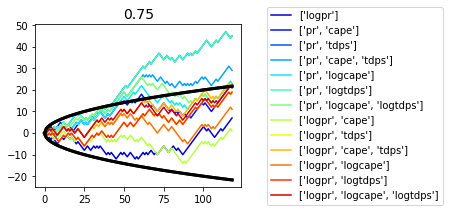

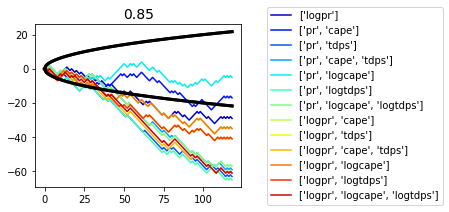

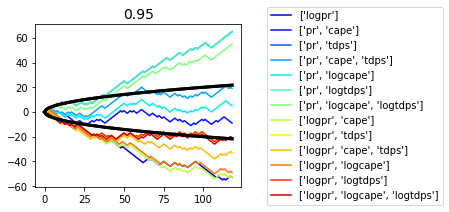

In [41]:
# CASO UTILIZZATO IN PROPOSAL
MEDIA = 1

if MEDIA ==1:
    X = Xm*1.
    y = ym*1.
else:
    X = Xall*1.
    y = yall*1.

threshold_perc_list = [0.75,0.85,0.95]


from itertools import combinations
import random

# set randomness . 1 for random, 0 for split time series
randpick=0
import random

if randpick==1:
#     picktrain = np.random.randint(0,int(X.shape[0]),int(X.shape[0]/2))
    # I pick values from the index, remember that I dropped a bunch of NaN so some index values are missing
    
#     picktrain = random.sample(range(X.shape[0]), int(X.shape[0]/2))
#     picktrain = np.sort(picktrain)
#     picktest = missing_elements(picktrain,0,int(X.shape[0])-1)
    X_trainT = X.iloc[picktrain]
    X_testT = X.iloc[picktest]
    y_trainT = y.iloc[picktrain]
    y_testT = y.iloc[picktest]                                  
                                  
#     X_trainT, X_testT, y_trainT, y_testT = train_test_split(X, y, test_size=0.5, random_state=0)
elif randpick==0:
    X_trainT = X[0:int(X.shape[0]/2)]
    y_trainT = y[0:int(X.shape[0]/2)].astype(int)
    X_testT = X[int(X.shape[0]/2):]
    y_testT = y[int(X.shape[0]/2):].astype(int)
elif randpick==-1:
    X_trainT = X[int(X.shape[0]/2):]
    y_trainT = y[int(X.shape[0]/2):].astype(int)
    X_testT = X[0:int(X.shape[0]/2)]
    y_testT = y[0:int(X.shape[0]/2)].astype(int)

for it,threshold_perc in enumerate(threshold_perc_list):
    # calculate occurrence and non occurence based on insample quantile so no leaking.
    y_trainT=(X_trainT.apcp_rep>=X_trainT.quantile(threshold_perc).apcp_rep).astype(int)
    y_testT =(X_testT.apcp_rep>=X_testT.quantile(threshold_perc).apcp_rep).astype(int)
    actual_forecast =(X_testT.pr>=X_testT.quantile(threshold_perc).pr).astype(int)

    # calculate climatology I start by copying the values as they are
    X_trainT['climo_precip'] = y_trainT*1.#X_trainT.apcp_rep*1.
    X_testT['climo_precip'] = y_testT*1.#X_testT.apcp_rep*1.
    # now substitute values per each month
    # GT = X_trainT.groupby(pd.Grouper(freq='M'))
    GT = X_trainT.groupby(X_trainT.index.month)
    X_trainT['climo_precip'] = GT.apcp_rep.transform(np.nanmean)

    # GT = X_testT.groupby(pd.Grouper(freq='M'))
    GT = X_testT.groupby(X_testT.index.month)
    X_testT['climo_precip'] = GT.apcp_rep.transform(np.nanmean)


    if MEDIA ==1:
        # calculate ensemble frequencym so I caclculate the observed probability along all ensemble members
        ds_merged_allMm = ds_merged_allM.mean(dim=['lat','lon'])
        ds_merged_M01 = (ds_merged_allMm.pr>X_trainT.quantile(threshold_perc).pr).mean('M').compute()
        df_merged_M01 = ds_merged_M01.to_dataframe()
        df_merged_M01 = df_merged_M01.reset_index()
        df_merged_M01.index.names = ['orig_rows']
        df_merged_M01.reset_index(inplace=True)
        df_merged_M01.set_index('T', inplace=True)
        ens_freq = df_merged_M01.loc[:, df_merged_M01.columns == 'pr']
    else:
        # calculate ensemble frequencym so I caclculate the observed probability along all ensemble members
#         ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).apcp_rep).mean('M').compute()
        ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).pr).mean('M').compute()
        df_merged_M01 = ds_merged_M01.to_dataframe()
        df_merged_M01 = df_merged_M01.reset_index()
        df_merged_M01.index.names = ['orig_rows']
        df_merged_M01.reset_index(inplace=True)
        df_merged_M01.set_index('T', inplace=True)
        ens_freq = df_merged_M01.loc[:, df_merged_M01.columns == 'pr']

    if randpick==1:
        X_trainT['ens_freq'] = ens_freq.iloc[X_trainT.orig_rows.values]
        X_testT['ens_freq'] = ens_freq.iloc[X_testT.orig_rows.values]
    elif randpick==0:
        X_trainT['ens_freq'] = ens_freq.iloc[X_trainT.orig_rows.values]
        X_testT['ens_freq'] = ens_freq.iloc[X_testT.orig_rows.values]
    elif randpick==-1:
        X_trainT['ens_freq'] = ens_freq.iloc[X_trainT.orig_rows.values]
        X_testT['ens_freq'] = ens_freq.iloc[X_testT.orig_rows.values]

    REAL = y_testT
    # Generate empty dataframe to put the reference values which I will use for the randomwalk plots
    # this needs to be the TEST segment of the data

    Prediction_test_rw = X_testT[['ens_freq']]*1.
    Prediction_test_rw['climo_only'] = X_testT[['climo_precip']]*1
    Prediction_test_rw['actual_forecast'] = actual_forecast*1
    plt.figure(figsize=(17,3))
    ax1 = plt.subplot(1,4,1)
#     ax2 = plt.subplot(1,4,2)
#     ax3 = plt.subplot(1,4,3)

    # all combinations of all models
    v1 = ['const']
    # varnamesall = ['logpr','pr', 'tas', 'tdps', 'cape', 'logcape', 'logtas', 'logtdps']
    # varnamesall = ['logpr','pr', 'logcape', 'logtas', 'logtdps']
    
#     varnamesall = ['logpr', 'logcape', 'logtas', 'logtdps']
#     l1 = list(combinations(varnamesall,1))
#     l2 = list(combinations(varnamesall,2))
#     l3 = list(combinations(varnamesall,3))
#     lall = l1+l2+l3
    #####################
    varnamesall = ['pr']
    la = list(combinations(varnamesall,1))
    varnamesall = ['logpr']
    lb = list(combinations(varnamesall,1))
    varnamesall = ['pr', 'cape',  'tdps']
    l2 = list(combinations(varnamesall,2))
    l3 = list(combinations(varnamesall,3))
    lall = la+lb+l2+l3#+lall
    varnamesall = ['pr', 'logcape',  'logtdps']
    l2 = list(combinations(varnamesall,2))
    l3 = list(combinations(varnamesall,3))
    lall = lall+l2+l3
    varnamesall = ['logpr','cape', 'tdps'] 
    l2 = list(combinations(varnamesall,2))
    l3 = list(combinations(varnamesall,3))
    lall = lall+l2+l3
    varnamesall = ['logpr', 'logcape', 'logtdps']
    l2 = list(combinations(varnamesall,2))
    l3 = list(combinations(varnamesall,3))
    lall = lall+l2+l3
    counterlall = 1
    for ic,iname in enumerate(lall):
        if (iname[0]!='pr')&(iname[0]!='logpr'):
            counterlall+=0
        else:
            counterlall+=1
            
    list_ef = 0.
    list_efpar = list()
    list_c = 0.
    list_cpar = list()
    list_af = 0.
    list_afpar = list()
    list_f = 0.
    list_fpar = list()
    colors_lines = plt.cm.jet(np.linspace(0,1,counterlall))

    flagpr=0
    counterlall=1
    for ic,iname in enumerate(lall):
        if (iname[0]!='pr')&(iname[0]!='logpr'):
            print('',)
        else:
            v2=v1+list(iname)
            X_train = X_trainT[v2]
            X_test = X_testT[v2]
            logit_model=sm.Logit(y_trainT,X_train)
            result1=logit_model.fit(disp=0,maxiter=100)
            predictions = result1.predict(X_test)
            PREDICTION_B = predictions*1.
#             list_ef1 = random_walk_mike_map(REAL, Prediction_test_rw['ens_freq'], 
#                                      PREDICTION_B ,'ensemble freq.',v2[1:], ax1,colors_lines[counterlall-1], 
#                                      legendflag=0)

#             list_af1 = random_walk_mike_map(REAL, Prediction_test_rw['actual_forecast'], 
#                                      PREDICTION_B ,'actual forecast',v2[1:], ax2,colors_lines[ic], 
#                                      legendflag=0)
#             ax1.set_ylabel(str(threshold_perc*100)+'%', fontsize=14)
#             if (list_ef1<0)&(list_ef1<=list_ef):
#                 list_ef=list_ef1*1.
#                 list_efpar = list(v2)
#             if (list_c1<0)&(list_c1<=list_c):
#                 list_c=list_c1*1.
#                 list_cpar = list(v2)
#             if (list_af1)<0&(list_af1<=list_af):
#                 list_af=list_af1*1.
#                 list_afpar = list(v2)


            if iname==('pr',):
    #             print('PROVA')
                Prediction_test_rw['pr_only'] = predictions*1.
            if iname!=('pr',):
                PREDICTION_B = predictions*1.
#                 random_walk_mike_map_BSS(REAL, Prediction_test_rw['logpr_only'], 
#                                          PREDICTION_B ,X_testT['climo_precip'],'log(pr) only 75%',v2[1:], ax3,colors_lines[ic], legendflag=1)
                list_f1=random_walk_mike_map(REAL, Prediction_test_rw['pr_only'], 
                                         PREDICTION_B,'pr only',v2[1:], 
                                             ax1,colors_lines[counterlall-1], 
                                     legendflag=1)
                if (list_f1<=list_f)&(list_f1<0):
                    list_f=list_f1*1.
                    list_fpar = list(v2)
            counterlall+=1

    print('EF ',list_ef)
#     print(list_efpar)
    print('F ',list_f)
    print(list_fpar)
    NN = len(pd.unique(X_testT.index))
    for ax in (ax1,ax1):#, ax3, ax4):
        ax.plot(np.arange(0,NN),2.*(np.arange(0,NN))**(1/2.),'k-',lw=3)
        ax.plot(np.arange(0,NN),-2.*(np.arange(0,NN))**(1/2.),'k-',lw=3)
        ax.set_title(threshold_perc, fontsize=14)


/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

0.3654830095805435




('pr',)
0.4078239343587407




('logpr', 'cape', 'tdps')
0.41530125959464936




('pr', 'cape', 'tdps')


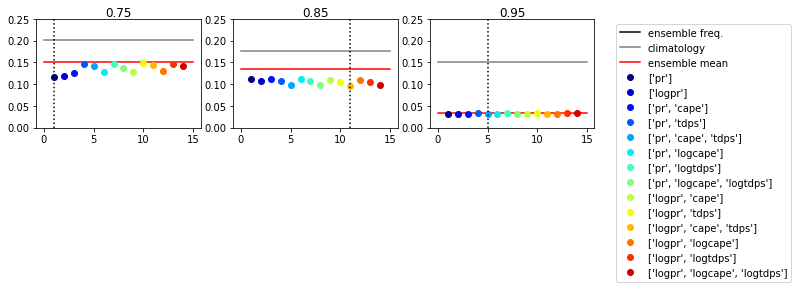

In [32]:
MEDIA = 1

if MEDIA ==1:
    X = Xm*1.
    y = ym*1.
else:
    X = Xall*1.
    y = yall*1.

from itertools import combinations
import random

# set threshold percentile
threshold_perc_list = [0.75,0.85,0.95]
symb_t = 'ox+'
linestyles = [ '-', '--', ':']
symb_t = 'ooo'
linestyles = [ '-', '-', '-']
# set randomness . 1 for random, 0 for split time series
randpick=0

import random
if randpick==1:
#     picktrain = np.random.randint(0,int(X.shape[0]),int(X.shape[0]/2))
    # I pick values from the index, remember that I dropped a bunch of NaN so some index values are missing
    
    picktrain = random.sample(range(X.shape[0]), int(X.shape[0]/2))
    picktrain = np.sort(picktrain)
    picktest = missing_elements(picktrain,0,int(X.shape[0])-1)
    X_trainT = X.iloc[picktrain]
    X_testT = X.iloc[picktest]
    y_trainT = y.iloc[picktrain]
    y_testT = y.iloc[picktest]                                  
                                  
#     X_trainT, X_testT, y_trainT, y_testT = train_test_split(X, y, test_size=0.5, random_state=0)
elif randpick==0:
    X_trainT = X[0:int(X.shape[0]/2)]
    y_trainT = y[0:int(X.shape[0]/2)].astype(int)
    X_testT = X[int(X.shape[0]/2):]
    y_testT = y[int(X.shape[0]/2):].astype(int)
elif randpick==-1:
    X_trainT = X[int(X.shape[0]/2):]
    y_trainT = y[int(X.shape[0]/2):].astype(int)
    X_testT = X[0:int(X.shape[0]/2)]
    y_testT = y[0:int(X.shape[0]/2)].astype(int)
    
plt.figure(figsize=(10,2))
for it,threshold_perc in enumerate(threshold_perc_list):
    ax = plt.subplot(1,3,it+1)

    # calculate occurrence and non occurence based on insample quantile so no leaking.
    y_trainT=(X_trainT.apcp_rep>=X_trainT.quantile(threshold_perc).apcp_rep).astype(int)
    y_testT =(X_testT.apcp_rep>=X_testT.quantile(threshold_perc).apcp_rep).astype(int)
    actual_forecast =(X_testT.pr>=X_testT.quantile(threshold_perc).pr).astype(int)


    # calculate climatology I start by copying the values as they are
    X_trainT['climo_precip'] = y_trainT*1.#X_trainT.apcp_rep*1.
    X_testT['climo_precip'] = y_testT*1.#X_testT.apcp_rep*1.
    # now substitute values per each month
    # GT = X_trainT.groupby(pd.Grouper(freq='M'))
    GT = X_trainT.groupby(X_trainT.index.month)
    X_trainT['climo_precip'] = GT.apcp_rep.transform(np.nanmean)

    # GT = X_testT.groupby(pd.Grouper(freq='M'))
    GT = X_testT.groupby(X_testT.index.month)
    X_testT['climo_precip'] = GT.apcp_rep.transform(np.nanmean)


    if MEDIA ==1:
        # calculate ensemble frequencym so I caclculate the observed probability along all ensemble members
#         ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).apcp_rep).mean(dim=['M','lat','lon']).compute()
        ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).pr).mean(dim=['M','lat','lon']).compute()
        df_merged_M01 = ds_merged_M01.to_dataframe()
        df_merged_M01 = df_merged_M01.reset_index()
        df_merged_M01.index.names = ['orig_rows']
        df_merged_M01.reset_index(inplace=True)
        df_merged_M01.set_index('T', inplace=True)
        ens_freq = df_merged_M01.loc[:, df_merged_M01.columns == 'pr']
    else:
        # calculate ensemble frequencym so I caclculate the observed probability along all ensemble members
#         ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).apcp_rep).mean('M').compute()
        ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).pr).mean('M').compute()
        df_merged_M01 = ds_merged_M01.to_dataframe()
        df_merged_M01 = df_merged_M01.reset_index()
        df_merged_M01.index.names = ['orig_rows']
        df_merged_M01.reset_index(inplace=True)
        df_merged_M01.set_index('T', inplace=True)
        ens_freq = df_merged_M01.loc[:, df_merged_M01.columns == 'pr']

    if randpick==1:
        X_trainT['ens_freq'] = ens_freq.iloc[X_trainT.orig_rows.values]
        X_testT['ens_freq'] = ens_freq.iloc[X_testT.orig_rows.values]
    elif randpick==0:
        X_trainT['ens_freq'] = ens_freq.iloc[X_trainT.orig_rows.values]
        X_testT['ens_freq'] = ens_freq.iloc[X_testT.orig_rows.values]
    elif randpick==-1:
        X_trainT['ens_freq'] = ens_freq.iloc[X_trainT.orig_rows.values]
        X_testT['ens_freq'] = ens_freq.iloc[X_testT.orig_rows.values]

    REAL = y_testT
    # Generate empty dataframe to put the reference values which I will use for the randomwalk plots
    # this needs to be the TEST segment of the data


    # all combinations of all models
    v1 = ['const']
    # varnamesall = ['logpr','pr', 'tas', 'tdps', 'cape', 'logcape', 'logtas', 'logtdps']
    # varnamesall = ['logpr','pr', 'logcape', 'logtas', 'logtdps']
#     varnamesall = ['logpr', 'logcape', 'logtas', 'logtdps']
#     l1 = list(combinations(varnamesall,1))
#     l2 = list(combinations(varnamesall,2))
#     l3 = list(combinations(varnamesall,3))
#     lall = l1+l2+l3
    #####################
#     varnamesall = ['pr', 'cape', 'tas', 'tdps']
#     l1 = list(combinations(varnamesall,1))
#     l2 = list(combinations(varnamesall,2))
#     l3 = list(combinations(varnamesall,3))
#     lall = l1+l2+l3#+lall
#     varnamesall = ['pr', 'logcape', 'logtas', 'logtdps']
#     l1 = list(combinations(varnamesall,1))
#     l2 = list(combinations(varnamesall,2))
#     l3 = list(combinations(varnamesall,3))
#     lall = lall+l1[1:]+l2+l3
#     varnamesall = ['logpr']
#     l1 = list(combinations(varnamesall,1))
#     varnamesall = ['logpr','cape', 'tas', 'tdps'] 
#     l2 = list(combinations(varnamesall,2))
#     l3 = list(combinations(varnamesall,3))
#     lall = lall+l1+l2+l3
#     varnamesall = ['logpr', 'logcape', 'logtas', 'logtdps']
#     l2 = list(combinations(varnamesall,2))
#     l3 = list(combinations(varnamesall,3))
#     lall = lall+l2+l3
    #####################
    varnamesall = ['pr']
    la = list(combinations(varnamesall,1))
    varnamesall = ['logpr']
    lb = list(combinations(varnamesall,1))
    varnamesall = ['pr', 'cape',  'tdps']
    l2 = list(combinations(varnamesall,2))
    l3 = list(combinations(varnamesall,3))
    lall = la+lb+l2+l3#+lall
    varnamesall = ['pr', 'logcape',  'logtdps']
    l2 = list(combinations(varnamesall,2))
    l3 = list(combinations(varnamesall,3))
    lall = lall+l2+l3
    varnamesall = ['logpr','cape', 'tdps'] 
    l2 = list(combinations(varnamesall,2))
    l3 = list(combinations(varnamesall,3))
    lall = lall+l2+l3
    varnamesall = ['logpr', 'logcape', 'logtdps']
    l2 = list(combinations(varnamesall,2))
    l3 = list(combinations(varnamesall,3))
    lall = lall+l2+l3
    counterlall = 1
    for ic,iname in enumerate(lall):
        if (iname[0]!='pr')&(iname[0]!='logpr'):
            counterlall+=0
        else:
            counterlall+=1
            
    
    ROCAUC = 1.
    ROCplace = 0.
    ROCplacecorretto = 0.
    ROCAUCpar = list()
    colors_lines = plt.cm.jet(np.linspace(0,1,counterlall))

    Prediction_test_rw = X_testT[['ens_freq']]*1.
    Prediction_test_rw['climo_only'] = X_testT[['climo_precip']]*1
    Prediction_test_rw['actual_forecast'] = actual_forecast*1

#     ROCAUC1 = np.nanmean((y_testT[np.isfinite(Prediction_test_rw['ens_freq'].values)]-
#                   Prediction_test_rw['ens_freq'].values[np.isfinite(Prediction_test_rw['ens_freq'].values)])**2)
    ROCAUC1 = np.nanmean((y_testT-
                  Prediction_test_rw['ens_freq'].values)**2)
    print( ROCAUC1)
    
    ax.plot([0,15],[ROCAUC1,ROCAUC1],linestyles[it],color='black',label='ensemble freq.')
#     ax.text(-0.8,ROCAUC1,threshold_perc,horizontalalignment='center',
#            verticalalignment='center',)
    ax.set_title(threshold_perc,horizontalalignment='center',
           verticalalignment='center',)
    ROCAUC1 = np.nanmean((y_testT-
                          Prediction_test_rw['climo_only'].values)**2)
    ax.plot([0,15],[ROCAUC1,ROCAUC1],linestyles[it],color='grey',label = 'climatology')
#     ax.text(-0.8,ROCAUC1,threshold_perc,horizontalalignment='center',
#            verticalalignment='center',)
    ROCAUC1 = np.nanmean((y_testT- 
                            Prediction_test_rw['actual_forecast'].values)**2)
    ax.plot([0,15],[ROCAUC1,ROCAUC1],linestyles[it],color='red',label='ensemble mean')

    flagpr=0
    counterlall = 1

    for ic,iname in enumerate(lall):
        if (iname[0]!='pr')&(iname[0]!='logpr'):
            print('',)
        else:
            v2=v1+list(iname)
            X_train = X_trainT[v2]
            X_test = X_testT[v2]
            logit_model=sm.Logit(y_trainT,X_train)
        #     model = LogisticRegression(C=1e8)
#             try:
            result1=logit_model.fit(disp=0,maxiter=100)
            predictions = result1.predict(X_test)
            ROCAUC1 = np.nanmean((y_testT-
                                  predictions.values)**2)
            ax.plot(counterlall,ROCAUC1,symb_t[it],color=colors_lines[counterlall-1],label=v2[1:])
#             print(ROCAUC1,ROCAUC)
            if ROCAUC1<ROCAUC:
                ROCAUC=ROCAUC1*1.
                ROCAUCpar = list(v2)
                ROCplace=ic
                ROCplacecorretto=counterlall
            counterlall+=1



#             except:
#                 print('error')
    if it==2:
        ax.legend( bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
    ax.set_ylim((0,0.25))
#     ax.set_xlim((-1.5,15))
    ax.plot([ROCplacecorretto,ROCplacecorretto],[0,0.25],'k:')
    print(lall[ROCplace])

In [76]:
lall

[('pr',),
 ('logpr',),
 ('pr', 'cape'),
 ('pr', 'tas'),
 ('pr', 'tdps'),
 ('cape', 'tas'),
 ('cape', 'tdps'),
 ('tas', 'tdps'),
 ('pr', 'cape', 'tas'),
 ('pr', 'cape', 'tdps'),
 ('pr', 'tas', 'tdps'),
 ('cape', 'tas', 'tdps'),
 ('pr', 'logcape'),
 ('pr', 'logtas'),
 ('pr', 'logtdps'),
 ('logcape', 'logtas'),
 ('logcape', 'logtdps'),
 ('logtas', 'logtdps'),
 ('pr', 'logcape', 'logtas'),
 ('pr', 'logcape', 'logtdps'),
 ('pr', 'logtas', 'logtdps'),
 ('logcape', 'logtas', 'logtdps'),
 ('logpr', 'cape'),
 ('logpr', 'tas'),
 ('logpr', 'tdps'),
 ('cape', 'tas'),
 ('cape', 'tdps'),
 ('tas', 'tdps'),
 ('logpr', 'cape', 'tas'),
 ('logpr', 'cape', 'tdps'),
 ('logpr', 'tas', 'tdps'),
 ('cape', 'tas', 'tdps'),
 ('logpr', 'logcape'),
 ('logpr', 'logtas'),
 ('logpr', 'logtdps'),
 ('logcape', 'logtas'),
 ('logcape', 'logtdps'),
 ('logtas', 'logtdps'),
 ('logpr', 'logcape', 'logtas'),
 ('logpr', 'logcape', 'logtdps'),
 ('logpr', 'logtas', 'logtdps'),
 ('logcape', 'logtas', 'logtdps')]

/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

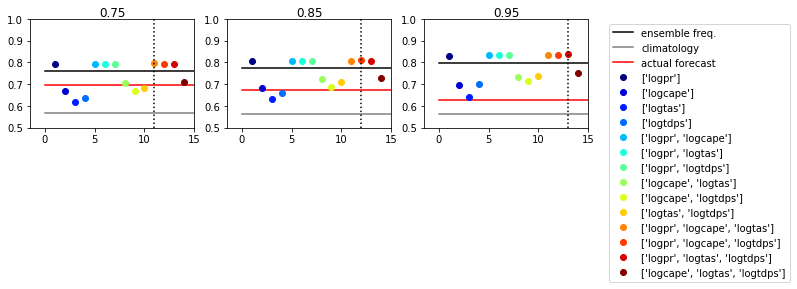

In [41]:
MEDIA = 0

if MEDIA ==1:
    X = Xm*1.
    y = ym*1.
else:
    X = Xall*1.
    y = yall*1.

from itertools import combinations
import random

# set threshold percentile
threshold_perc_list = [0.75,0.85,0.95]
symb_t = 'ox+'
linestyles = [ '-', '--', ':']
symb_t = 'ooo'
linestyles = [ '-', '-', '-']
# set randomness . 1 for random, 0 for split time series
randpick=1

import random
if randpick==1:
#     picktrain = np.random.randint(0,int(X.shape[0]),int(X.shape[0]/2))
    # I pick values from the index, remember that I dropped a bunch of NaN so some index values are missing
    
    picktrain = random.sample(range(X.shape[0]), int(X.shape[0]/2))
    picktrain = np.sort(picktrain)
    picktest = missing_elements(picktrain,0,int(X.shape[0])-1)
    X_trainT = X.iloc[picktrain]
    X_testT = X.iloc[picktest]
    y_trainT = y.iloc[picktrain]
    y_testT = y.iloc[picktest]                                  
                                  
#     X_trainT, X_testT, y_trainT, y_testT = train_test_split(X, y, test_size=0.5, random_state=0)
elif randpick==0:
    X_trainT = X[0:int(X.shape[0]/2)]
    y_trainT = y[0:int(X.shape[0]/2)].astype(int)
    X_testT = X[int(X.shape[0]/2):]
    y_testT = y[int(X.shape[0]/2):].astype(int)
elif randpick==-1:
    X_trainT = X[int(X.shape[0]/2):]
    y_trainT = y[int(X.shape[0]/2):].astype(int)
    X_testT = X[0:int(X.shape[0]/2)]
    y_testT = y[0:int(X.shape[0]/2)].astype(int)
    
plt.figure(figsize=(10,2))
for it,threshold_perc in enumerate(threshold_perc_list):
    ax = plt.subplot(1,3,it+1)

    # calculate occurrence and non occurence based on insample quantile so no leaking.
    y_trainT=(X_trainT.apcp_rep>=X_trainT.quantile(threshold_perc).apcp_rep).astype(int)
    y_testT =(X_testT.apcp_rep>=X_testT.quantile(threshold_perc).apcp_rep).astype(int)
    actual_forecast =(X_testT.pr>=X_testT.quantile(threshold_perc).pr).astype(int)


    # calculate climatology I start by copying the values as they are
    X_trainT['climo_precip'] = y_trainT*1.#X_trainT.apcp_rep*1.
    X_testT['climo_precip'] = y_testT*1.#X_testT.apcp_rep*1.
    # now substitute values per each month
    # GT = X_trainT.groupby(pd.Grouper(freq='M'))
    GT = X_trainT.groupby(X_trainT.index.month)
    X_trainT['climo_precip'] = GT.apcp_rep.transform(np.nanmean)

    # GT = X_testT.groupby(pd.Grouper(freq='M'))
    GT = X_testT.groupby(X_testT.index.month)
    X_testT['climo_precip'] = GT.apcp_rep.transform(np.nanmean)


    if MEDIA ==1:
        # calculate ensemble frequencym so I caclculate the observed probability along all ensemble members
#         ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).apcp_rep).mean(dim=['M','lat','lon']).compute()
        ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).pr).mean(dim=['M','lat','lon']).compute()
        df_merged_M01 = ds_merged_M01.to_dataframe()
        df_merged_M01 = df_merged_M01.reset_index()
        df_merged_M01.index.names = ['orig_rows']
        df_merged_M01.reset_index(inplace=True)
        df_merged_M01.set_index('T', inplace=True)
        ens_freq = df_merged_M01.loc[:, df_merged_M01.columns == 'pr']
    else:
        # calculate ensemble frequencym so I caclculate the observed probability along all ensemble members
#         ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).apcp_rep).mean('M').compute()
        ds_merged_M01 = (ds_merged_allM.pr>X_trainT.quantile(threshold_perc).pr).mean('M').compute()
        df_merged_M01 = ds_merged_M01.to_dataframe()
        df_merged_M01 = df_merged_M01.reset_index()
        df_merged_M01.index.names = ['orig_rows']
        df_merged_M01.reset_index(inplace=True)
        df_merged_M01.set_index('T', inplace=True)
        ens_freq = df_merged_M01.loc[:, df_merged_M01.columns == 'pr']

    if randpick==1:
        X_trainT['ens_freq'] = ens_freq.iloc[X_trainT.orig_rows.values]
        X_testT['ens_freq'] = ens_freq.iloc[X_testT.orig_rows.values]
    elif randpick==0:
        X_trainT['ens_freq'] = ens_freq.iloc[X_trainT.orig_rows.values]
        X_testT['ens_freq'] = ens_freq.iloc[X_testT.orig_rows.values]
    elif randpick==-1:
        X_trainT['ens_freq'] = ens_freq.iloc[X_trainT.orig_rows.values]
        X_testT['ens_freq'] = ens_freq.iloc[X_testT.orig_rows.values]

    REAL = y_testT
    # Generate empty dataframe to put the reference values which I will use for the randomwalk plots
    # this needs to be the TEST segment of the data


    # all combinations of all models
    v1 = ['const']
    # varnamesall = ['logpr','pr', 'tas', 'tdps', 'cape', 'logcape', 'logtas', 'logtdps']
    # varnamesall = ['logpr','pr', 'logcape', 'logtas', 'logtdps']
    varnamesall = ['logpr', 'logcape', 'logtas', 'logtdps']
    l1 = list(combinations(varnamesall,1))
    l2 = list(combinations(varnamesall,2))
    l3 = list(combinations(varnamesall,3))
    lall = l1+l2+l3
    ROCAUC = 0.
    ROCplace = 0.
    ROCAUCpar = list()
    colors_lines = plt.cm.jet(np.linspace(0,1,len(lall)))

    Prediction_test_rw = X_testT[['ens_freq']]*1.
    Prediction_test_rw['climo_only'] = X_testT[['climo_precip']]*1
    Prediction_test_rw['actual_forecast'] = actual_forecast*1

    ROCAUC1 = roc_auc_score(y_testT[np.isfinite(Prediction_test_rw['ens_freq'].values)], Prediction_test_rw['ens_freq'].values[np.isfinite(Prediction_test_rw['ens_freq'].values)])
    ax.plot([0,15],[ROCAUC1,ROCAUC1],linestyles[it],color='black',label='ensemble freq.')
#     ax.text(-0.8,ROCAUC1,threshold_perc,horizontalalignment='center',
#            verticalalignment='center',)
    ax.set_title(threshold_perc,horizontalalignment='center',
           verticalalignment='center',)
    ROCAUC1 = roc_auc_score(y_testT[np.isfinite(Prediction_test_rw['climo_only'].values)], Prediction_test_rw['climo_only'].values[np.isfinite(Prediction_test_rw['climo_only'].values)])
    ax.plot([0,15],[ROCAUC1,ROCAUC1],linestyles[it],color='grey',label = 'climatology')
#     ax.text(-0.8,ROCAUC1,threshold_perc,horizontalalignment='center',
#            verticalalignment='center',)
    ROCAUC1 = roc_auc_score(y_testT[np.isfinite(Prediction_test_rw['actual_forecast'].values)], 
                            Prediction_test_rw['actual_forecast'].values[np.isfinite(Prediction_test_rw['actual_forecast'].values)])
    ax.plot([0,15],[ROCAUC1,ROCAUC1],linestyles[it],color='red',label='actual forecast')

    flagpr=0
    for ic,iname in enumerate(lall):
#         print(iname)
        v2=v1+list(iname)
        X_train = X_trainT[v2]
        X_test = X_testT[v2]
        logit_model=sm.Logit(y_trainT,X_train)
    #     model = LogisticRegression(C=1e8)
        if (iname!=('logpr','pr'))&(iname!=('logcape','cape'))&(iname!=('logtas','tas')):
            try:
                result1=logit_model.fit(disp=0,maxiter=100)
                predictions = result1.predict(X_test)
                ROCAUC1 = roc_auc_score(y_testT[np.isfinite(predictions.values)], predictions.values[np.isfinite(predictions.values)])
                ax.plot(ic+1,ROCAUC1,symb_t[it],color=colors_lines[ic],label=v2[1:])
                if ROCAUC1>ROCAUC:
                    ROCAUC=ROCAUC1*1.
                    ROCAUCpar = list(v2)
                    ROCplace=ic+1


            except:
                print('error')
    if it==2:
        ax.legend( bbox_to_anchor=(1.1, 1), loc='upper left')
    ax.set_ylim((0.5,1))
    ax.set_xlim((-1.5,15))
    ax.plot([ROCplace,ROCplace],[0.5,1],'k:')
    

In [207]:
from itertools import combinations
import random

# set threshold percentile
threshold_perc = 0.85

randpick=1
   
coefvalues = np.zeros((len(np.arange(32, 43)),len(np.arange(257, 271))))
aucvalues = np.zeros((len(np.arange(32, 43)),len(np.arange(257, 271))))

for ilat, latx in enumerate(np.arange(32, 43)):
    for ilon, lonx in enumerate(np.arange(257, 271)):
        df_temp = df_merged[(df_merged.lat==latx)&(df_merged.lon==lonx)]#.dropna()
        
        Xallb = df_temp[['orig_rows','apcp_rep','pr','tas','tdps','cape','logpr','logcape','logtas','logtdps']]
        yallb = df_temp.loc[:, df_temp.columns == 'y']
        Xallb['const']=1
        print(Xallb.shape)
        if randpick==1:
#             if (ilat==0)&(ilon==0):
            picktrain = random.sample(range(Xallb.shape[0]), int(Xallb.shape[0]/2))
            picktrain = np.sort(picktrain)
            picktest = missing_elements(picktrain,0,int(Xallb.shape[0])-1)
            X_trainT = Xallb.iloc[picktrain]
            X_testT = Xallb.iloc[picktest]
            y_trainT = yallb.iloc[picktrain]
            y_testT = yallb.iloc[picktest]                                  

        #     X_trainT, X_testT, y_trainT, y_testT = train_test_split(X, y, test_size=0.5, random_state=0)
        elif randpick==0:
            X_trainT = Xallb[0:int(Xallb.shape[0]/2)]
            y_trainT = yallb[0:int(Xallb.shape[0]/2)].astype(int)
            X_testT = Xallb[int(Xallb.shape[0]/2):]
            y_testT = yallb[int(Xallb.shape[0]/2):].astype(int)
        elif randpick==-1:
            X_trainT = Xallb[int(Xallb.shape[0]/2):]
            y_trainT = yallb[int(Xallb.shape[0]/2):].astype(int)
            X_testT = Xallb[0:int(Xallb.shape[0]/2)]
            y_testT = yallb[0:int(Xallb.shape[0]/2)].astype(int)
        X_trainT=X_trainT.dropna()
        X_testT=X_testT.dropna()
        y_trainT=y_trainT.dropna()
        y_testT=y_testT.dropna()
        # calculate occurrence and non occurence based on insample quantile so no leaking.
        y_trainT=(X_trainT.apcp_rep>=X_trainT.quantile(threshold_perc).apcp_rep).astype(int)
        y_testT =(X_testT.apcp_rep>=X_testT.quantile(threshold_perc).apcp_rep).astype(int)
        actual_forecast =(X_testT.pr>=X_testT.quantile(threshold_perc).pr).astype(int)       
    #     print(y_trainT.head(10))
        varname=['const','logpr','logtdps' ]   
        X_train = X_trainT[varname]
        X_test = X_testT[varname]
        logit_model=sm.Logit(y_trainT,X_train)
    #     model = LogisticRegression(C=1e8)
        result1=logit_model.fit(disp=1,maxiter=100)
        predictions = result1.predict(X_test)
        ROCAUC1 = roc_auc_score(y_testT[np.isfinite(predictions.values)], predictions.values[np.isfinite(predictions.values)])
        coefvalues[ilat,ilon]= result1.params[1]
        aucvalues[ilat,ilon]= ROCAUC1



/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(237, 11)
Optimization terminated successfully.
         Current function value: 0.373883
         Iterations 8
(235, 11)
Optimization terminated successfully.
         Current function value: 0.367033
         Iterations 8
(234, 11)
Optimization terminated successfully.
         Current function value: 0.343694
         Iterations 8
(233, 11)
Optimization terminated successfully.
         Current function value: 0.312614
         Iterations 9
(233, 11)
Optimization terminated successfully.
         Current function value: 0.331271
         Iterations 9
(236, 11)
Optimization terminated successfully.
         Current function value: 0.268092
         Iterations 9
(237, 11)
Optimization terminated successfully.
         Current function value: 0.318719
         Iterations 8
(236, 11)
Optimization terminated successfully.
         Current function value: 0.240646
         Iterations 10
(236, 11)
Optimization terminated successfully.
         Current function value: 0.266884
         Iter

(237, 11)
Optimization terminated successfully.
         Current function value: 0.314499
         Iterations 9
(237, 11)
Optimization terminated successfully.
         Current function value: 0.343302
         Iterations 9
(237, 11)
Optimization terminated successfully.
         Current function value: 0.362554
         Iterations 8
(237, 11)
Optimization terminated successfully.
         Current function value: 0.377782
         Iterations 8
(237, 11)
Optimization terminated successfully.
         Current function value: 0.330227
         Iterations 8
(237, 11)
Optimization terminated successfully.
         Current function value: 0.314391
         Iterations 8
(237, 11)
Optimization terminated successfully.
         Current function value: 0.362572
         Iterations 8
(237, 11)
Optimization terminated successfully.
         Current function value: 0.393365
         Iterations 8
(237, 11)
Optimization terminated successfully.
         Current function value: 0.405845
         Itera

Optimization terminated successfully.
         Current function value: 0.339615
         Iterations 8
(237, 11)
Optimization terminated successfully.
         Current function value: 0.382586
         Iterations 8
(237, 11)
Optimization terminated successfully.
         Current function value: 0.343844
         Iterations 8
(237, 11)
Optimization terminated successfully.
         Current function value: 0.333574
         Iterations 8
(237, 11)
Optimization terminated successfully.
         Current function value: 0.360907
         Iterations 8
(237, 11)
Optimization terminated successfully.
         Current function value: 0.375816
         Iterations 7


In [208]:
cmap1 = plt.cm.get_cmap('hot_r', 5) 
ds_merged['aucvalues']=(('lat','lon'),aucvalues)

ds_merged.aucvalues.plot(vmax=1, vmin=0.5,
            cmap=cmap1)

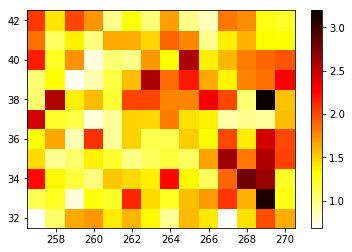

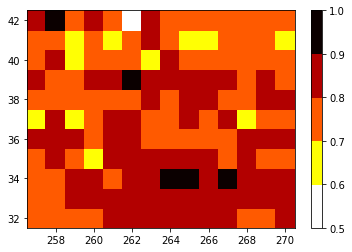

In [199]:
plt.figure()
plt.pcolor(np.arange(257, 272)-0.5,np.arange(32, 44)-0.5,coefvalues, cmap='hot_r')
plt.colorbar()
plt.figure()

cmap1 = plt.cm.get_cmap('hot_r', 5)    # 11 discrete colors


plt.pcolor(np.arange(257, 272)-0.5,np.arange(32, 44)-0.5, aucvalues,
            vmax=1, vmin=0.5,
            cmap=cmap1)
# plt.contourf(np.arange(257, 272)-0.5,np.arange(32, 44)-0.5,aucvalues,vmin=0.5,vmax=1,
#             cmap='hot_r')
plt.colorbar()

# Comparing monthly average prob>0.85 with the one from the forecast

/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

0.6468531468531469
0.4254643206256109
0.2993977631201606
0.583502759221609
0.3834710743801653
0.16518275538894095
0.5060034305317324
0.35934819897084047
0.48019235172887564
0.5165847665847666
0.4144641301190822
0.3640875253778479
0.756534090909091
0.36386827458256027
0.39503588516746413
0.7429567237873947
0.5983827493261455
0.6049853372434018
0.5381428223251279
0.40163242330425
0.6404428904428904
0.15568181818181817
0.5294298921417566
0.33900881726968685
0.5326310968628348
0.6157804459691252
0.49283835135925164
0.34860606060606064
0.6002886002886003
0.42486562280906753
0.6917613636363636
0.5168744299179082
0.6451762523191094
0.44368600682593856
0.5056446821152704
0.5614156835530881
0.45910515816471925
0.4977567886658795
0.45698051948051943
0.5746857643963754
0.21248630887185105
0.4249073810202336
0.4144945963127781
0.6067937438905181
0.5351048951048952
0.5454545454545454
0.44810307802433785
0.7247735082786629
0.5217932752179327
0.6136363636363636
0.6968673218673218
0.5649531526968853
0

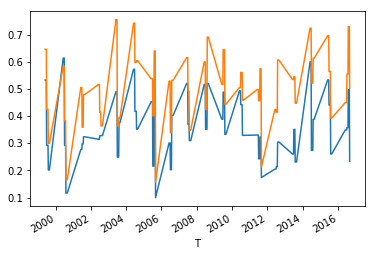

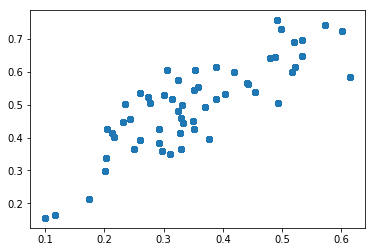

In [86]:
X_testT.climo_precip.plot()
X_testT['ens_freq_Mon_mean'] = X_testT['climo_precip']*1.
for k, v in  X_testT.reset_index().set_index('T').groupby(pd.Grouper(freq='M')).indices.items():
    media = np.nanmean( X_testT['ens_freq'].iloc[v].values)
    print(media)
#     media = np.nanmean( y_trainT.iloc[v].values)
    X_testT['ens_freq_Mon_mean'].iloc[v] =media
    del media

X_testT.ens_freq_Mon_mean.plot()
plt.figure()
plt.plot(X_testT.climo_precip,X_testT.ens_freq_Mon_mean,'o')


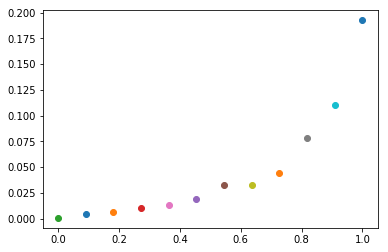

In [90]:
for iu in X_trainT.ens_freq.unique():
    plt.plot(iu,y_trainT[X_trainT.ens_freq==iu].mean(),'o')

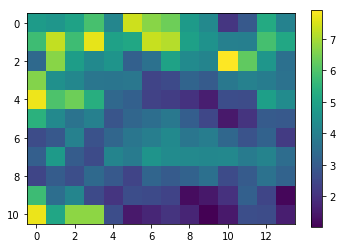

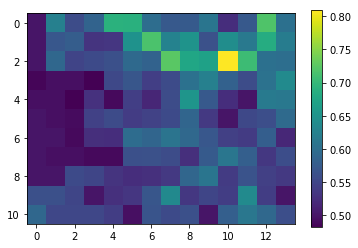

In [333]:
plt.figure()
plt.imshow(coefvalues)
plt.colorbar()
plt.figure()
plt.imshow(aucvalues)
plt.colorbar()

In [491]:
import numpy as np
from scipy.stats import chi2
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

def likelihood_ratio_test(features_alternate, labels, lr_model, features_null=None):
    """
    Compute the likelihood ratio test for a model trained on the set of features in
    `features_alternate` vs a null model.  If `features_null` is not defined, then
    the null model simply uses the intercept (class probabilities).  Note that
    `features_null` must be a subset of `features_alternative` -- it can not contain
    features that are not in `features_alternate`.
    Returns the p-value, which can be used to accept or reject the null hypothesis.
    """
    labels = np.array(labels)
    features_alternate = np.array(features_alternate)
    
#     if features_null!=None:
#         features_null = np.array(features_null)
        
#         if features_null.shape[1] >= features_alternate.shape[1]:
#             raise ValueError, "Alternate features must have more features than null features"
        
    lr_model.fit(features_null, labels)
    print(lr_model.coef_)
    null_prob = lr_model.predict_proba(features_null)[:, 1]
    df = features_alternate.shape[1] - features_null.shape[1]
    print(df)
#     else:
#         null_prob = sum(labels) / float(labels.shape[0]) * \
#                     np.ones(labels.shape)
#         df = features_alternate.shape[1]
    
    lr_model.fit(features_alternate, labels)
    alt_prob = lr_model.predict_proba(features_alternate)
    print(lr_model.coef_)
    alt_log_likelihood = -log_loss(labels,
                                   alt_prob,
                                   normalize=False)
    null_log_likelihood = -log_loss(labels,
                                    null_prob,
                                    normalize=False)
    print(alt_log_likelihood,null_log_likelihood)
    G = 2 * (alt_log_likelihood - null_log_likelihood)
    p_value = chi2.sf(G, df)

    return p_value

In [462]:
def plot_pvalues( p_values, title):
    log_p_values = np.log10(p_values)
    plt.clf()
    plt.boxplot(x=log_p_values)
    plt.xlabel("Variable", fontsize=16)
    plt.ylabel("P-Value (log10)", fontsize=16)
    plt.title(title, fontsize=18)
#     plt.savefig(flname, DPI=200)


In [ ]:
for i in xrange(len(CORR_PROBS)):
    # force into Nx1 matrix
    column = features[:, i].reshape(-1, 1)
    p_value = likelihood_ratio_test(column,
                                    labels,
                                    model)
    feature_log_p_values[j, i] = p_value
    
plot_pvalues(feature_log_p_values,
                 "")


In [104]:
# varname=['const','pr','tdps']
# X_trainT, X_testT, y_trainT, y_testT = train_test_split(X, y, test_size=0.7, random_state=0)
# y_trainT = y_trainT.astype(int)
# y_testT = y_testT.astype(int)
# X_train = X_trainT[varname]
# X_test = X_testT[varname]
# logit_model=sm.Logit(y_trainT,X_train)
# result1=logit_model.fit()
# # print(result1.summary2())
# predictions = result1.predict(X_test)
# predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]
# print(classification_report(y_testT, predictions_nominal, digits=3))
# print(metrics.confusion_matrix(y_testT, predictions_nominal))


# where_1 = y_trainT[y_trainT==1]
# where_0 = y_trainT[y_trainT==0]
# for ir in range(0,10):
#     NN = y_trainT[y_trainT==1].count()
#     print(NN.values)
#     which_0 = where_0.dropna().sample(NN.values*2).index    
#     XX0 = X_train.loc[which_0]
#     XX1 = X_train.loc[where_1.dropna().index]
#     YY0 = where_0.dropna().loc[which_0]
#     YY1 = where_1.dropna()
#     logit_model=sm.Logit(pd.concat([YY1,YY0]),pd.concat([XX1,XX0]))
#     result1=logit_model.fit()
# #     print(result1.summary2())
#     predictions = result1.predict(X_test)
#     predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]
#     print(classification_report(y_testT, predictions_nominal, digits=3))
#     print(metrics.confusion_matrix(y_testT, predictions_nominal))


['pr', 'tas', 'cape']


/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0
[[ 1.15968929e+00 -7.12871208e-03  8.05000073e-04]]
[0.0293331]
Accuracy of logistic regression classifier on test set: 0.77
log loss: 0.4984
0.5460477092658165


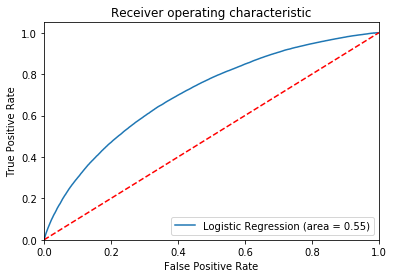

['pr', 'tas']


/home/clepore/.conda/envs/general_python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0
[[ 1.34034886 -0.02272774]]
[5.17836996]
Accuracy of logistic regression classifier on test set: 0.77
log loss: 0.5053
0.540276782365082


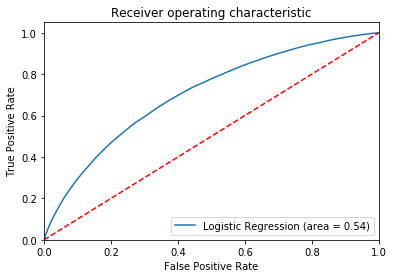

0.0


In [459]:
varname=['pr','tas' ,'cape'   ] 
print(varname)
X_train = X_trainT[varname]
X_test = X_testT[varname]
logreg = LogisticRegression(C=1e8)
logreg.fit(X_train, y_train)
print(logreg.verbose)
print(logreg.coef_)
print(logreg.intercept_)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('log loss: {:.4f}' .format(log_loss(y_test, logreg.predict_proba(X_test)))) 
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
logregA = logreg
X_testA = X_test
alt_log_likelihood = -log_loss(y_test, logregA.predict_proba(X_test), normalize=False)

varname=['pr','tas'   ] 
print(varname)
X_train = X_trainT[varname]
X_test = X_testT[varname]
logreg = LogisticRegression(C=1e8)
logreg.fit(X_train, y_train)
print(logreg.verbose)
print(logreg.coef_)
print(logreg.intercept_)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('log loss: {:.4f}' .format(log_loss(y_test, logreg.predict_proba(X_test)))) 
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
logregB = logreg
X_testB = X_test
null_log_likelihood = -log_loss(y_test, logregB.predict_proba(X_test), normalize=False)

G = 2 * (alt_log_likelihood - null_log_likelihood)
df = X_testA.shape[1] - X_testB.shape[1]
p_value = chi2.sf(G, df)
print(p_value)
